In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_json("train.json")

In [3]:
def normalize(v):
    minv = np.min(v)
    maxv = np.max(v)
    res = (v-minv)/(maxv-minv)
    return res

In [4]:
data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [5]:
HH = np.asarray(np.vstack(data.band_1.values))
HV = np.asarray(np.vstack(data.band_2.values))
HB = HH/HV

In [6]:
R = normalize(HH)
G = normalize(HV)
B = normalize(HB)

In [7]:
print R.shape, G.shape, B.shape

(1604, 5625) (1604, 5625) (1604, 5625)


In [8]:
label = np.asarray(np.vstack(data.is_iceberg.values))

In [9]:
label.shape

(1604, 1)

In [10]:
ims_h = np.hstack((R,G,B))
ims = ims_h.reshape(1604,3,75,75).transpose(0,2,3,1).astype("float")
ims.shape

(1604, 75, 75, 3)

In [11]:
def displayimage(ims, id):
    plt.imshow(ims[id],cmap='inferno')
    plt.grid(False)
    plt.title(data.is_iceberg[id])
    plt.show()

In [12]:
gims = color.rgb2gray(ims)

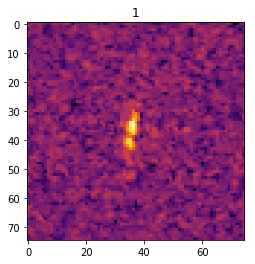

In [13]:
displayimage(gims,10)

In [14]:
import tensorflow as tf

In [15]:
def split_train_test(size, train_pc):
    ind = range(size)
    np.random.shuffle(ind)
    slice_split = int(train_pc*size)
    train_ind, test_ind = ind[:slice_split],ind[slice_split:]
    return train_ind, test_ind

In [16]:
train_ind, test_ind = split_train_test(len(label),train_pc=0.8)

In [17]:
def flatten_images(ip_ims):
    res_ims = ip_ims.reshape(-1,75*75)
    return res_ims

In [18]:
gims_flat = flatten_images(gims)

In [19]:
Xtrain, Xval = gims_flat[train_ind],gims_flat[test_ind]
Ytrain, Yval = label[train_ind],label[test_ind]

In [20]:
le = OneHotEncoder(sparse=False)
Yval_o = le.fit_transform(Yval)

Ytrain_o = le.fit_transform(Ytrain)

In [21]:
#displayimage(Xtrain,3)

In [22]:
def generate_batch(Xdata, Ydata, batch_size):
    ind = range(len(Ydata))
    np.random.shuffle(ind)
    return Xdata[ind[:batch_size]], Ydata[ind[:batch_size]]

Creating the Tensorflow graph for the architecture

In [23]:
X = tf.placeholder(tf.float32,[None,75*75])
Y = tf.placeholder(tf.int32,[None,2])

In [24]:
W1 = tf.Variable(tf.truncated_normal(shape=[75*75,1028],stddev=0.1))
b1 = tf.Variable(tf.constant(0.1, shape=[1028]))

In [25]:
layer1 = tf.nn.sigmoid(tf.matmul(X,W1) + b1)

In [26]:
W2 = tf.Variable(tf.truncated_normal(shape=[1028,2],stddev=0.1))
b2 = tf.Variable(tf.constant(0.1,shape=[2]))

In [27]:
y = tf.matmul(layer1,W2) + b2

In [28]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=y))

In [29]:
train_step = tf.train.AdamOptimizer(1e-5).minimize(cross_entropy)

In [30]:
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        xbatch,ybatch = generate_batch(Xtrain,Ytrain_o,32)
        if i%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={X:xbatch,Y:ybatch})
            print("step %d, training accuracy %g"%(i,train_accuracy))
        train_step.run(feed_dict={X:xbatch,Y:ybatch})
    
    print("test accuracy %g" % accuracy.eval(feed_dict={X:Xval,Y:Yval_o}))
        

step 0, training accuracy 0.46875
step 100, training accuracy 0.4375
step 200, training accuracy 0.53125
step 300, training accuracy 0.5625
step 400, training accuracy 0.6875
step 500, training accuracy 0.34375
step 600, training accuracy 0.4375
step 700, training accuracy 0.46875
step 800, training accuracy 0.6875
step 900, training accuracy 0.59375
step 1000, training accuracy 0.65625
step 1100, training accuracy 0.53125
step 1200, training accuracy 0.6875
step 1300, training accuracy 0.6875
step 1400, training accuracy 0.5
step 1500, training accuracy 0.5
step 1600, training accuracy 0.59375
step 1700, training accuracy 0.71875
step 1800, training accuracy 0.59375
step 1900, training accuracy 0.625
step 2000, training accuracy 0.46875
step 2100, training accuracy 0.5625
step 2200, training accuracy 0.625
step 2300, training accuracy 0.6875
step 2400, training accuracy 0.59375
step 2500, training accuracy 0.53125
step 2600, training accuracy 0.625
step 2700, training accuracy 0.5625
